In [1]:
### IMPORT SCIENTIFIC LIBRARIES ###
import numpy as np
import pandas as pd
from scipy import sparse
from scipy.optimize import curve_fit
import lmfit as lm
from tqdm import tqdm
from contextlib import redirect_stdout
import io


import matplotlib.pyplot as plt
plt.rcParams['font.size'], plt.rcParams['axes.labelsize'] = 14, 18
import sys, importlib

import sys
sys.path.append('./XPCSlibrary/')

import ID10_tools as ID10
from ID10_tools import Nx, Ny, Npx
importlib.reload(ID10)
ID10.set_version('v2')

import XPCS_tools as XPCS
from XPCS_tools import E2lambda, lambda2E, theta2Q, Q2theta, decorrelation_f
importlib.reload(XPCS)
XPCS.set_beamline('ID10')

import COSMICRAY_tools as COSMIC
importlib.reload(COSMIC)
COSMIC.set_beamline('ID10')

### EXPERIMENTAL VARIABLES ###
XPCS.set_expvar(Nx//2, Ny//2, 5)
ID10.Nfmax_dense_file = 2000
ID10.Nfmax_sparse_file = 5000

from folder_paths import *

## Load masks

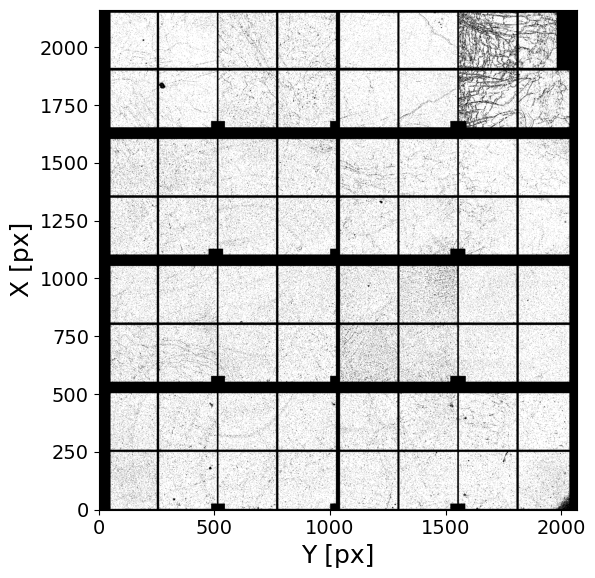

In [2]:
e4m_mask = np.load(MASKS_folder+'e4m_mask'+'.npy')
e4m_htmask = np.load(MASKS_folder+'e4m_htmask_Mo_fluorescence'+'.npy')

plt.figure(figsize=(6, 6))
plt.imshow((e4m_mask*e4m_htmask).reshape(Nx,Ny), cmap='gray', origin='lower')
plt.xlabel('Y [px]')
plt.ylabel('X [px]')
plt.tight_layout(); plt.show()

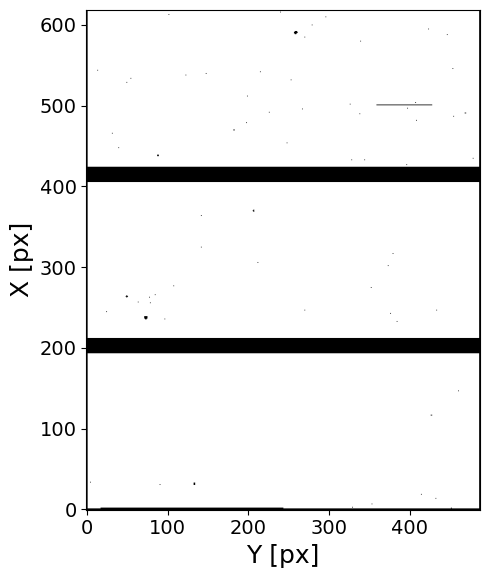

In [3]:
pilatus_mask = np.load(MASKS_folder+'pilatus300k_mask_20240201'+'.npy').astype(bool)

plt.figure(figsize=(6, 6))
plt.imshow(~pilatus_mask, cmap='gray', origin='lower')
plt.xlabel('Y [px]')
plt.ylabel('X [px]')
plt.tight_layout(); plt.show()

## Q mask

In [4]:
###########
Q = 1.6
dq = 0.01
###########
Q=float(Q)

## XPCS scan: delcoup=8, T=~5h (Ta2O5_2.5um_asdep, 4, 7)  


#############################
command = mtimescan 0.001 1 16000128
Ei = 21.669991317784486
itime = 0.0011
T =  4.888928 h
theta = 8.0
Qc = 1.53
#############################



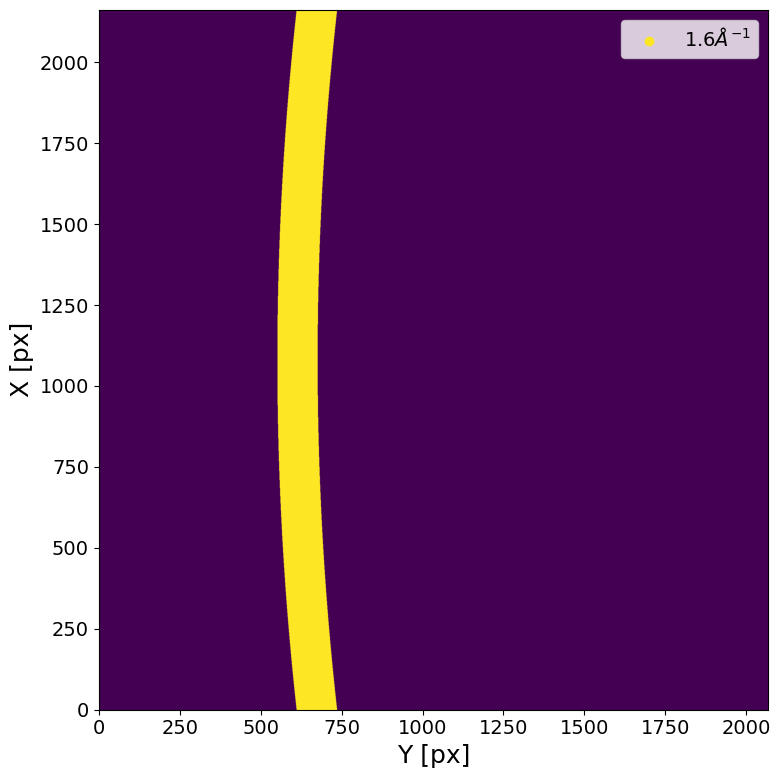

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00050.h5 (51/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00051.h5 (52/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00003.h5 (4/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00004.h5 (5/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00005.h5 (6/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00052.h5 (53/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00006.h5 (7/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00053.h5 (54/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00054.h5 (55/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00055.h5 (56/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00007.h5 (8/201 loops)
	 -> loading file eiger4m_v2_sp

In [5]:
#######################################
sample_name = 'Ta2O5_2.5um_asdep'
Ndataset = 4
Nscan = 7
#######################################

scan = ID10.load_scan(RAW_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
T = scan['fast_timer_period'].size*itime
theta = scan['delcoup']
Qc = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('T = ', T/60**2, 'h')
print('theta =', theta)
print('Qc =', Qc)
print('#############################\n')

#################################################################################
Nfi, Nff = None, int(1e6)
Qmask = XPCS.gen_Qmask(Ei, theta, Q, dq, Qmap_plot=False)
Kossel_mask = np.load(MASKS_folder+'Kossel_mask_Ta2O5_2.5um_asdep_0002_0001.npy')
load_mask = e4m_mask*e4m_htmask*Qmask#*Kossel_mask
##################################################################################

e4m_data = ID10.load_sparse_e4m(RAW_folder, sample_name, Ndataset, Nscan, Nfi=Nfi, Nff=Nff, load_mask=load_mask, n_jobs=50, )

### Flux check

################################################################################
Maximum count in the whole run -> 3.0
# of pixels above Ith_high treshold ->  4245884 pixels (of 4471016 => 94.96 %)
# of pixels below Ith_low treshold ->  0 pixels (of 4471016 => 0.0 %)
################################################################################



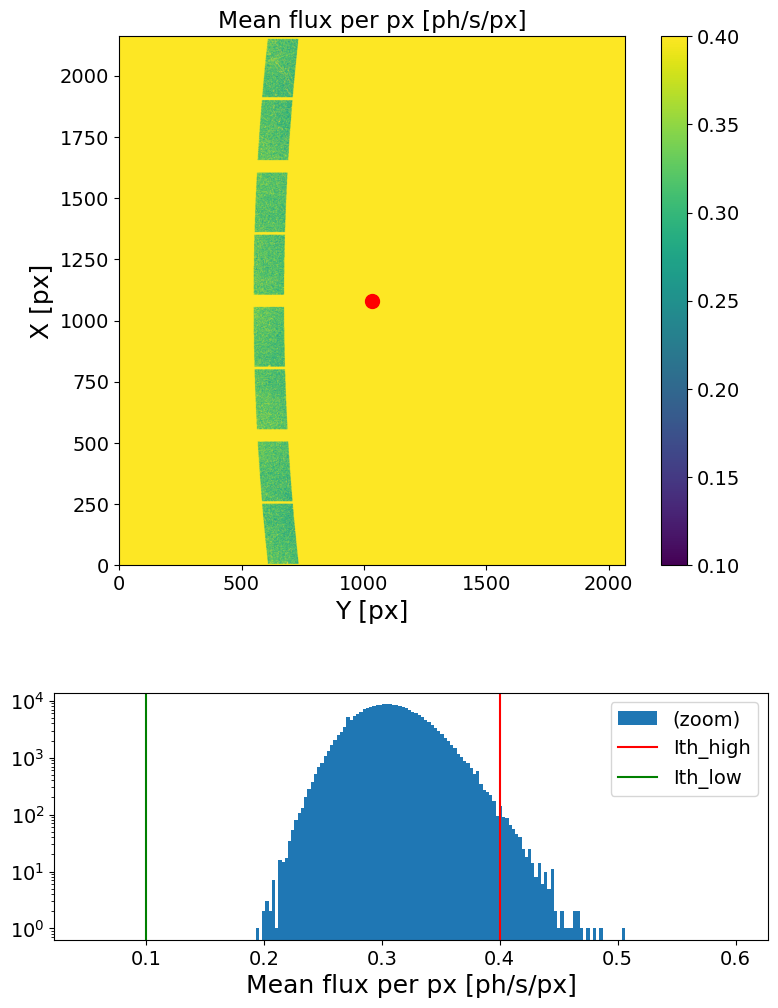

In [6]:
XPCS.gen_plots4mask(e4m_data, itime, Ith_low=.1, Ith_high=0.4, Nfi=None, Nff=int(1e7), load_mask=load_mask, mask=None)

### Intensity analysis

In [7]:
####################
Lbin = 100
Nstep = 100
mask = None
Nfi = None
Nff = None
####################

t_It, It = XPCS.get_It(e4m_data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep, Nfi=Nfi, Nff=Nff)
np.savez(It_folder+'Idt_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq), t_It=t_It, It=It)

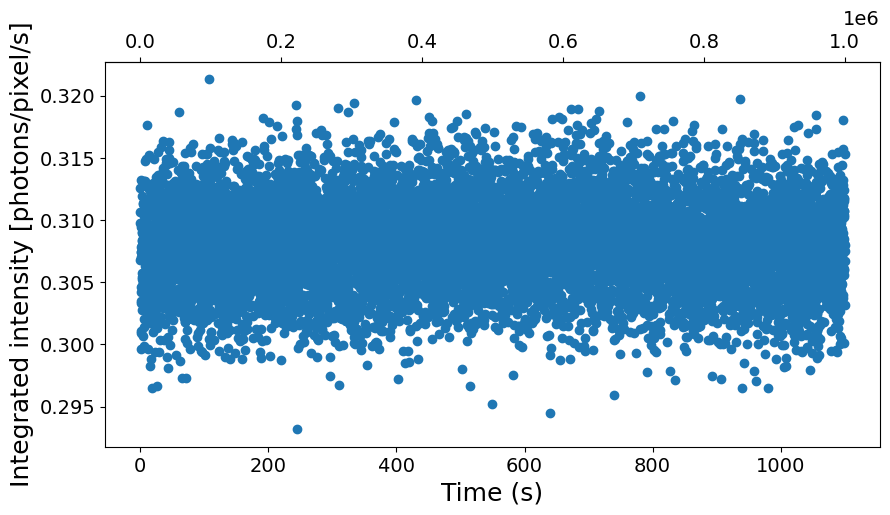

In [8]:
plt.figure(figsize=(10,5))
plt.scatter(t_It, It, label='It')
plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))
#plt.xscale('log')
plt.show()

### Linear correlation 4 tests

In [27]:
###################
Nfi = None
Nff = int(3e4)
Lbin = 100
bin2dense = False
mask = None
###################
if Lbin is None: Lbin=1

G2t = XPCS.get_G2t(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, bin2dense=bin2dense)

Loading frames ...
Done! (elapsed time = 0.01 s)
Binning frames (Lbin = 100, using MKL library) ...
Done! (elapsed time = 0.01 s)
	 | 300 frames X 225764 pixels
	 | sparsity = 3.32e-02
	 | memory usage (sparse.csr_array @ float32) = 0.025 GB
Computing G2t (using MKL library)...
Done! (elapsed time = 0.07 s)
	 | 300 X 300 squared matrix
	 | memory usage (np.array @ float32) = 0.0 GB
Normalizing G2t (using NumExpr library)...
Done! (elapsed time = 0.0 s)



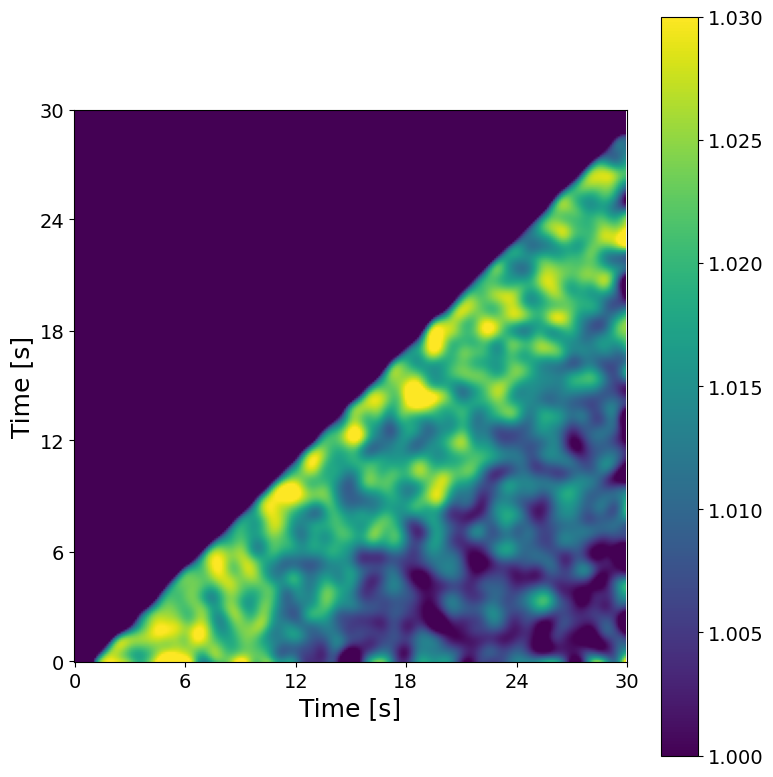

In [28]:
############################
t1, t2 = 0, 30
vmin, vmax = 1.0, 1.03
############################
XPCS.plot_G2t(G2t, vmin, vmax, itime*Lbin, t1=t1, t2=t2, sigma_filter=4)

In [29]:
################
Nbunch = 3
################

NfXbunch = int(G2t.shape[0]/Nbunch)
t_g2, g2, dg2, t_mt, g2_mt, dg2_mt = {}, {}, {}, {}, {}, {}
for n in range(Nbunch):
    if Nfi is None: Nfi = 0
    t_bunch = Nfi*itime + round(itime*Lbin*NfXbunch*(n+1/2),1)

    if Nbunch!=1: t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t[NfXbunch*n:NfXbunch*(n+1), NfXbunch*n:NfXbunch*(n+1)]))
    else:         t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t))
    t_mt[t_bunch], g2_mt[t_bunch], dg2_mt[t_bunch] = XPCS.get_g2mt_fromling2(itime*Lbin, g2[t_bunch],dg2[t_bunch])   


Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)

Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)

Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)



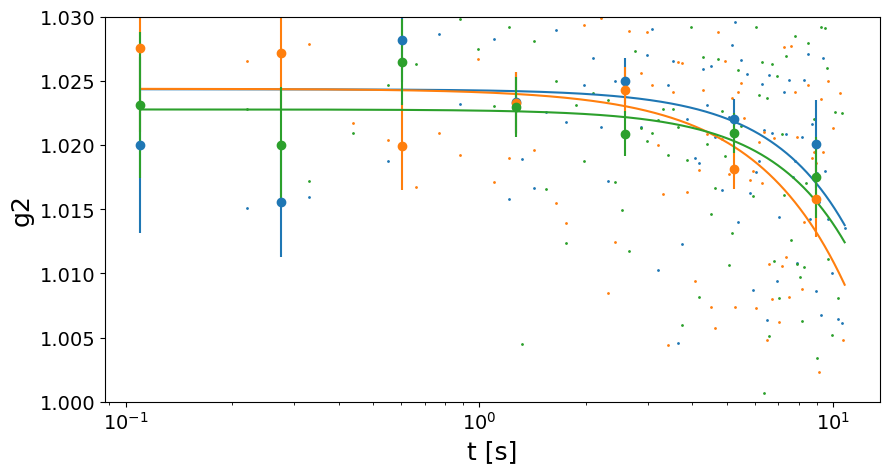

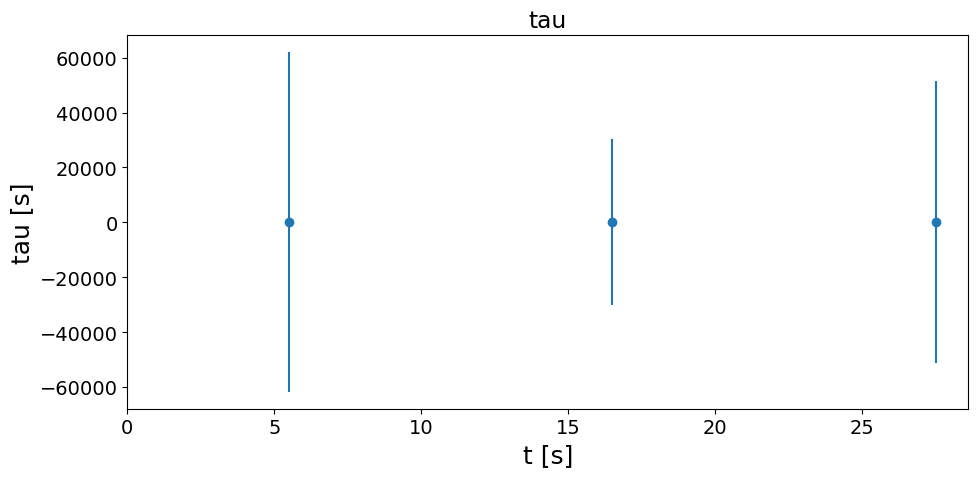

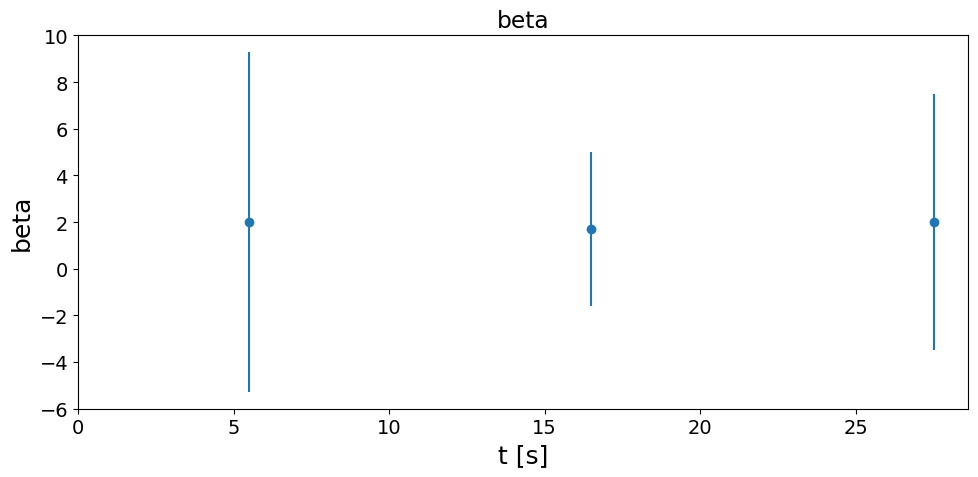

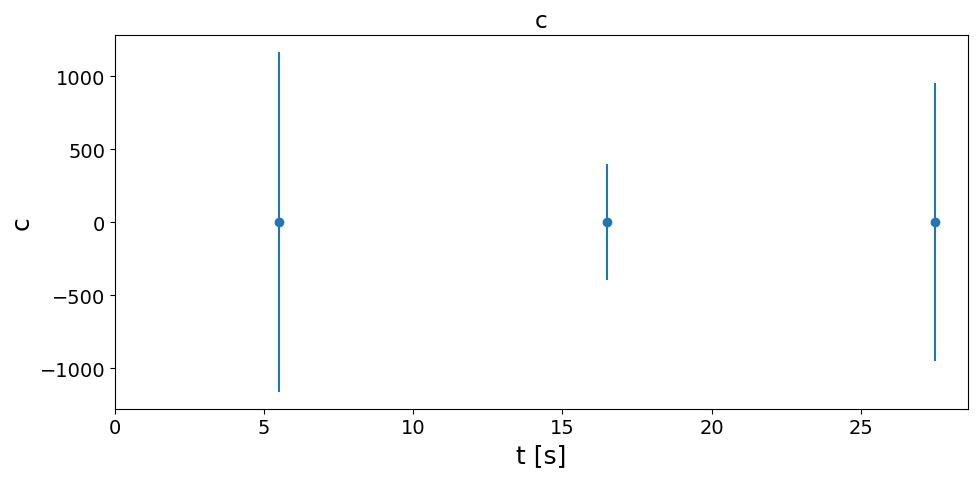

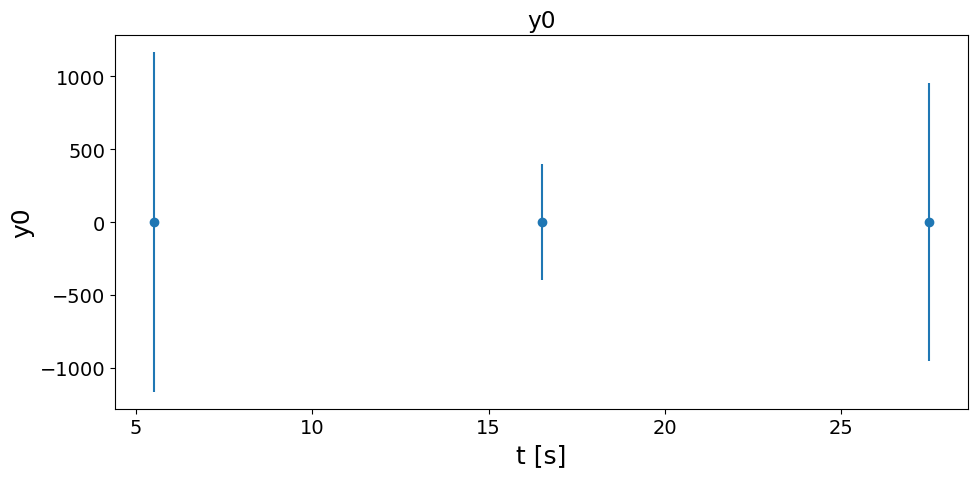

In [30]:
##################
t1_fit = 0
t2_fit = 1e100
##################

#####################################################
model = lm.Model(decorrelation_f)
params = lm.Parameters()
params.add('tau', value=100, min=0, max=1e6)
params.add('beta', value=1, min=0, max=2)
params.add('c', value=.02, min=0, max=1)
params.add('y0', value=1, min=0, max=2)
#params.add('y0', value=1.015, vary=False)
#####################################################
 
plt.figure(figsize=(10,5))
g2_fit = pd.DataFrame(columns=['Q', 'dQ', 'tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
g2_fit.index.name = 't'
for i,k in enumerate(g2.keys()):
    plt.scatter(t_g2[k], g2[k], s=1, c='C'+str(i), label = str(k)+'s')
    t_mt, g2_mt, dg2_mt = XPCS.get_g2mt_fromling2(itime*Lbin, g2[k], dg2[k])
    plt.errorbar(t_mt, g2_mt, yerr=dg2_mt, fmt = 'o', c='C'+str(i), label=str(k)+'s')
    
    x = t_g2[k] [(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    y = g2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    dy = dg2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    fit = model.fit(y, params, t=x, method='least_squares', weights=1/dy)
    g2_fit.loc[k] = [Q, dq, fit.params['tau'].value, fit.params['beta'].value, fit.params['c'].value, fit.params['y0'].value, fit.params['tau'].stderr, fit.params['beta'].stderr, fit.params['c'].stderr, fit.params['y0'].stderr]

    x = np.arange(np.min(t_g2[k]), np.max(t_g2[k]), 1e-2)
    y = decorrelation_f(x, *g2_fit.loc[k].values[2:6])
    plt.plot(x, y,)

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.ylim(1, 1.03)
#plt.legend()
plt.show()

if Nbunch == 1:
    display(fit.params)
else:
    plt.figure(figsize=(10,5))
    plt.title('tau')
    plt.errorbar(g2_fit.index, g2_fit.tau,  yerr=g2_fit.dtau, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('tau [s]')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('beta')
    plt.errorbar(g2_fit.index, g2_fit.beta,  yerr=g2_fit.dbeta, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('beta')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('c')
    plt.errorbar(g2_fit.index, g2_fit.c,  yerr=g2_fit.dc, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('c')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('y0')
    plt.errorbar(g2_fit.index, g2_fit.y0,  yerr=g2_fit.dy0, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('y0')
    plt.tight_layout(); plt.show()

### Linear by dose

In [15]:
t_ff = e4m_data.shape[0]*itime
print('#############################')
print('Nff =    =',e4m_data.shape[0], ' =>  t_ff =', t_ff)
print('#############################\n')

#############################
Nff =    = 14067151  =>  t_ff = 15473.866100000001
#############################



In [40]:
########################################
#N_segments = 5
t_segments = [0, 50, 200, 500, 1000]#[0, 200, 500, 1000, 2000, 5000, 15400] #np.linspace(0, int(t_ff), N_segments)
t_skip = [] # skip if Nfi is in t_skip
########################################

Nf_segments = [int (t/itime) for t in t_segments]
Nf_skip = [int(t/itime) for t in t_skip]

In [41]:
###################
Lbin = 100
bin2dense = False
mask = None
###################

t_g2, g2, dg2= {}, {}, {}
for i in tqdm(range(len(Nf_segments)-1)):
    with redirect_stdout(io.StringIO()):
        Nfi = Nf_segments[i]
        Nff = Nf_segments[i+1]
        if not Nfi in Nf_skip:
            G2t = XPCS.get_G2t(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, bin2dense=bin2dense)
            t_bunch = Nfi*itime + (Nff-Nfi)/2*itime
            t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t))
np.savez(g2_folder+'g2_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq), t_g2=t_g2, g2=g2, dg2=dg2)

 50%|█████     | 2/4 [00:05<00:06,  3.08s/it]/gpfs/jazzy/data/visitor/hc6211/id10-coh/20250527/SCRIPTS_Trento/XPCSlibrary/XPCS_tools.py:827: RuntimeWarning: invalid value encountered in sqrt
  if    G2t.dtype==np.float32: g2, dg2 = mean_trace_float32(G2t)
100%|██████████| 4/4 [00:17<00:00,  4.46s/it]


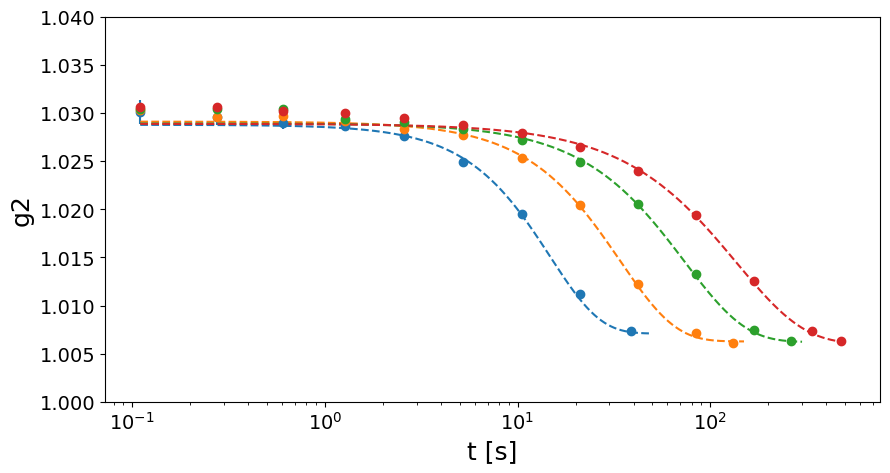

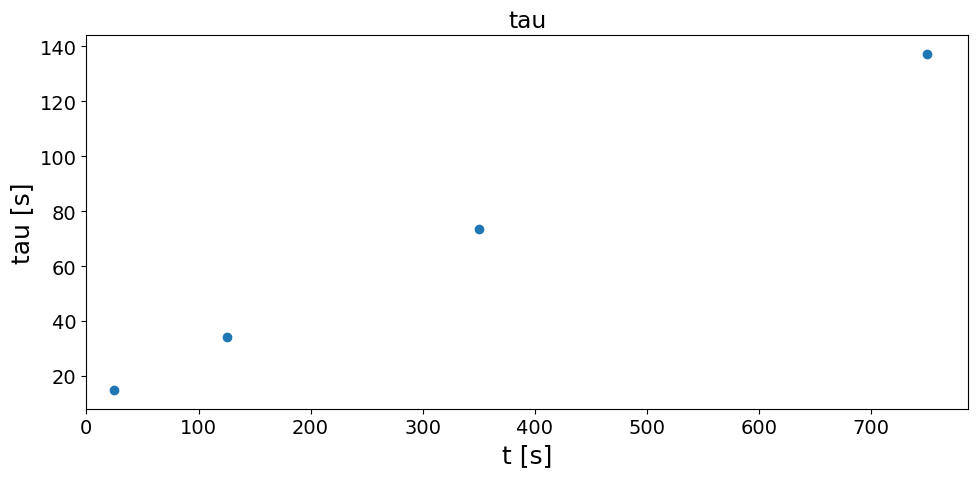

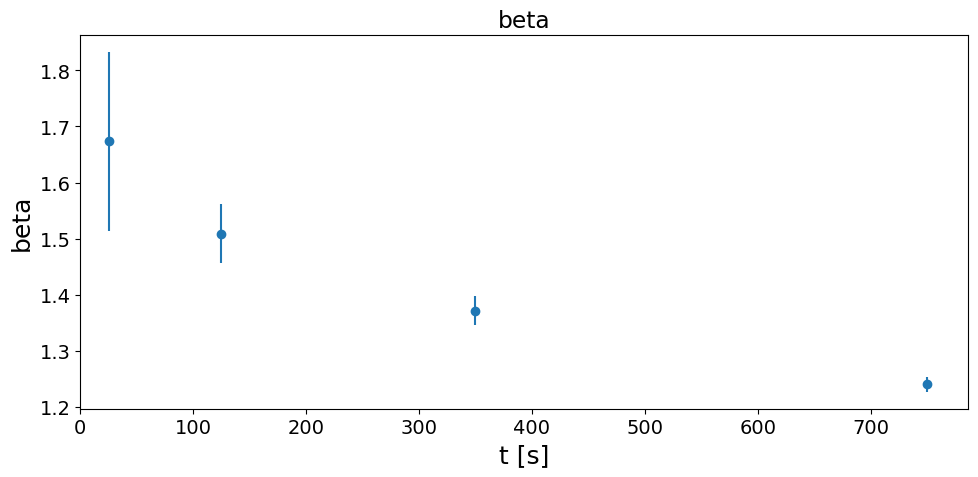

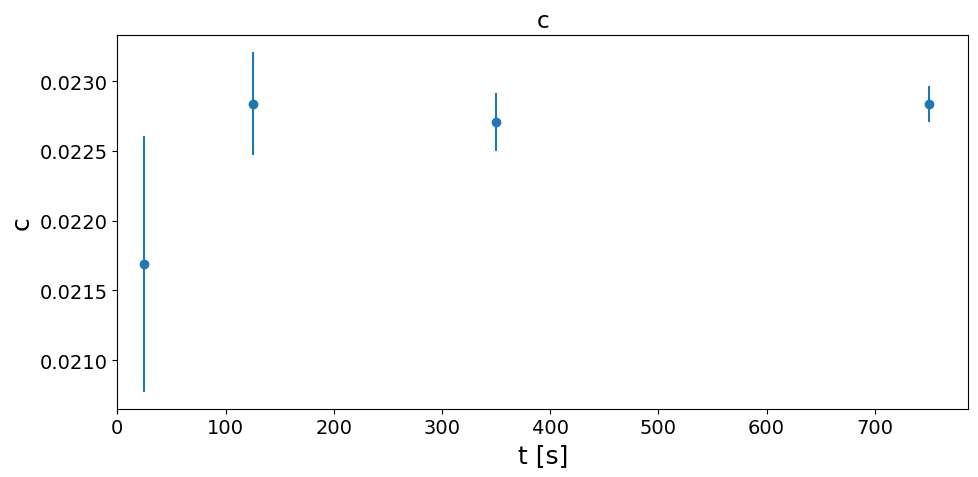

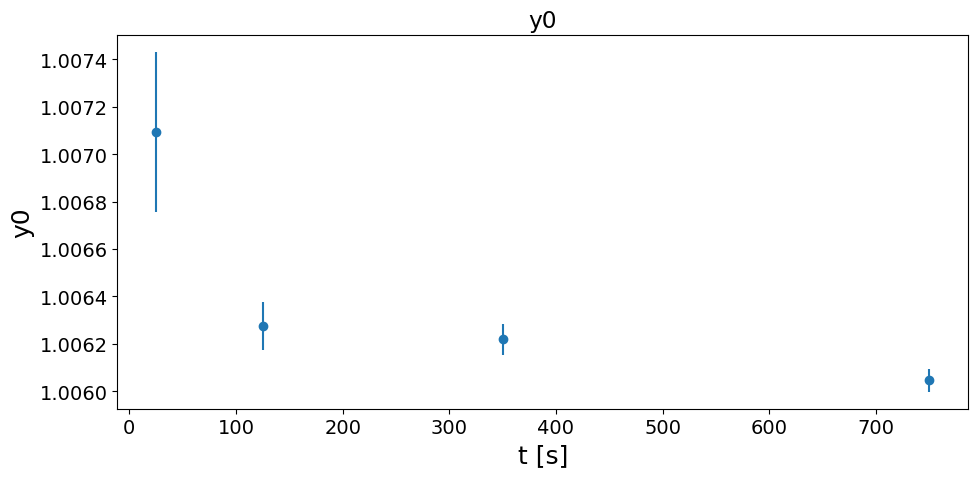

In [42]:
##################
t1_fit = 0
t2_fit = 1e10
##################

#####################################################
model = lm.Model(decorrelation_f)
params = lm.Parameters()
params.add('tau', value=50, min=0, max=1e6)
params.add('beta', value=0.8, min=0, max=2)
params.add('c', value=.02, min=0, max=1)
params.add('y0', value=1, min=0, max=2)
#params.add('y0', value=1.00249580, vary=False)
#####################################################
 
plt.figure(figsize=(10,5))
g2_fit = pd.DataFrame(columns=['Q', 'dQ', 'tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
g2_fit.index.name = 't'
for i,k in enumerate(g2.keys()):
    #plt.scatter(t_g2[k], g2[k], s=1, c='C'+str(i), label = str(k)+'s')
    t_mt, g2_mt, dg2_mt = XPCS.get_g2mt_fromling2(itime*Lbin, g2[k], dg2[k])
    plt.errorbar(t_mt, g2_mt, yerr=dg2_mt, fmt = 'o', c='C'+str(i), label=str(k)+'s')

    x = t_g2[k] [(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    y = g2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    dy = 0.01#dg2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    fit = model.fit(y, params, t=x, method='least_squares', weights=1/dy)
    g2_fit.loc[k] = [Q, dq, fit.params['tau'].value, fit.params['beta'].value, fit.params['c'].value, fit.params['y0'].value, fit.params['tau'].stderr, fit.params['beta'].stderr, fit.params['c'].stderr, fit.params['y0'].stderr]

    x = np.arange(np.min(t_g2[k]), np.max(t_g2[k]), 1e-2)
    y = decorrelation_f(x, *g2_fit.loc[k].values[2:6])
    plt.plot(x, y, c='C'+str(i), linestyle='--')

g2_fit.to_csv(g2fit_folder+'g2fit_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq)+'.csv')

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.ylim(1, 1.04)
#plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title('tau')
plt.errorbar(g2_fit.index, g2_fit.tau,  yerr=g2_fit.dtau, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('tau [s]')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('beta')
plt.errorbar(g2_fit.index, g2_fit.beta,  yerr=g2_fit.dbeta, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('beta')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('c')
plt.errorbar(g2_fit.index, g2_fit.c,  yerr=g2_fit.dc, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('c')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('y0')
plt.errorbar(g2_fit.index, g2_fit.y0,  yerr=g2_fit.dy0, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('y0')
plt.tight_layout(); plt.show()

## XPCS scan: delcoup=8, T=8h (Ta2O5_2.5um_B, 1, 5)  

Tantala annealed, macro notte

#############################
command = mtimescan 0.001 1 28800048
Ei = 21.669991317784486
itime = 0.0011
T =  8.800014666666668 h
theta = 8.0
Qc = 1.53
#############################



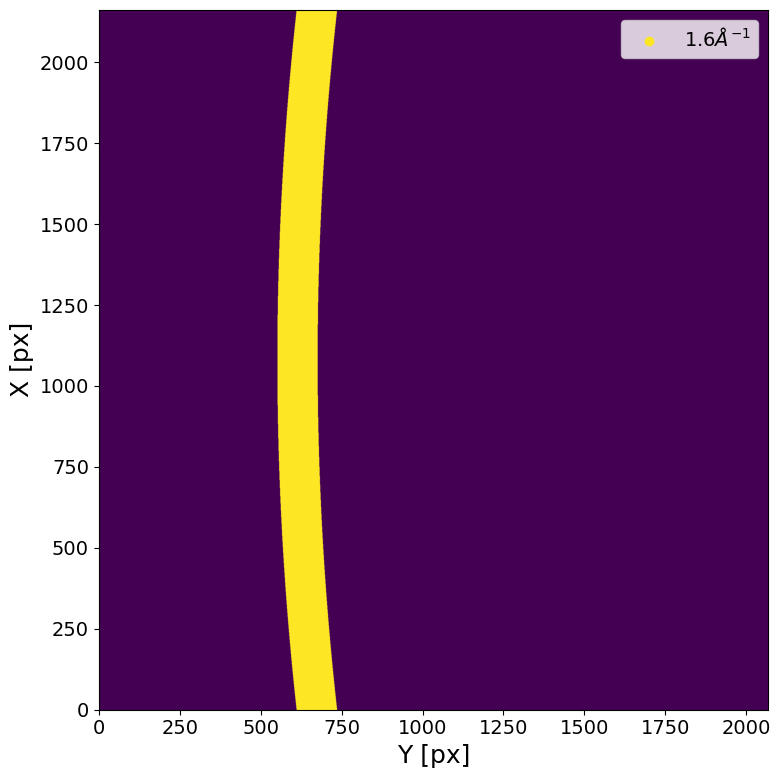

In [45]:
#######################################
sample_name = 'Ta2O5_2.5um_B'
Ndataset = 1
Nscan = 5
#######################################

scan = ID10.load_scan(RAW_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
T = scan['fast_timer_period'].size*itime
theta = scan['delcoup']
Qc = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('T = ', T/60**2, 'h')
print('theta =', theta)
print('Qc =', Qc)
print('#############################\n')

#################################################################################
Nfi, Nff = None, None
Qmask = XPCS.gen_Qmask(Ei, theta, Q, dq, Qmap_plot=False)
load_mask = e4m_mask*e4m_htmask*Qmask
##################################################################################


#e4m_data = ID10.load_sparse_e4m(RAW_folder, sample_name, Ndataset, Nscan, Nfi=Nfi, Nff=Nff, load_mask=load_mask, n_jobs=50, )

### Flux check

################################################################################
Maximum count in the whole run -> 2.0
# of pixels above Ith_high treshold ->  4246729 pixels (of 4471016 => 94.98 %)
# of pixels below Ith_low treshold ->  4327 pixels (of 4471016 => 0.1 %)
################################################################################



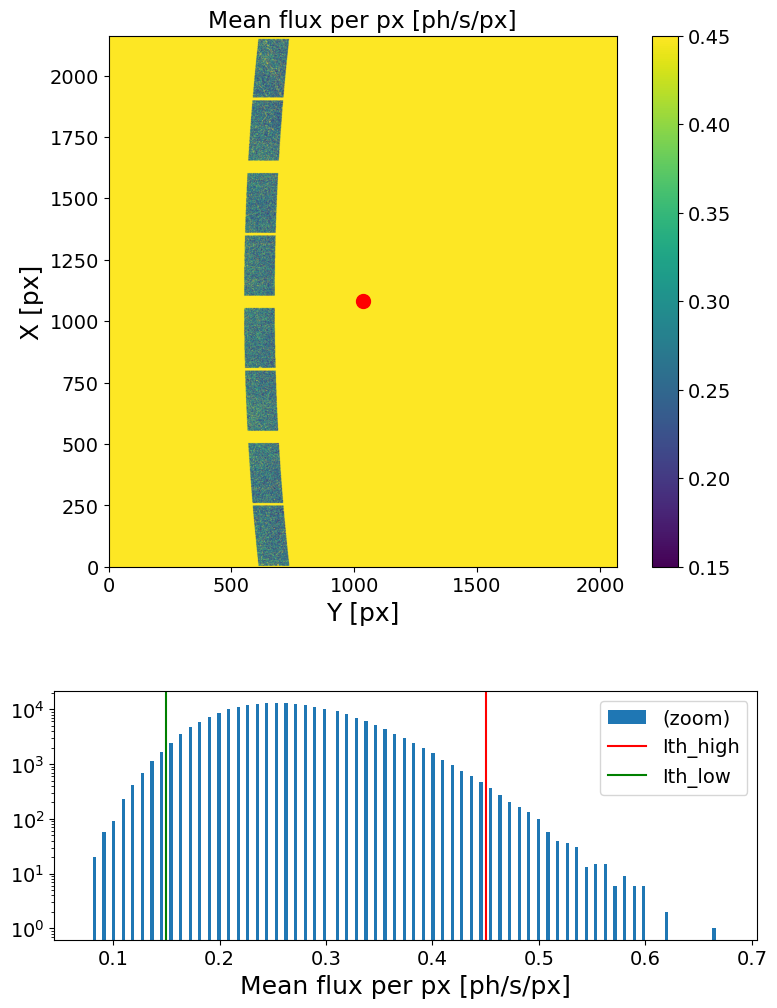

In [6]:
XPCS.gen_plots4mask(e4m_data, itime, Ith_low=.15, Ith_high=.45, Nfi=None, Nff=int(1e5), load_mask=load_mask, mask=None)

### Intensity analysis

In [7]:
####################
Lbin = 1000
Nstep = 1000
mask = None
Nfi = None
Nff = None
####################

t_It, It = XPCS.get_It(e4m_data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep, Nfi=Nfi, Nff=Nff)
np.savez(It_folder+'Idt_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq), t_It=t_It, It=It)

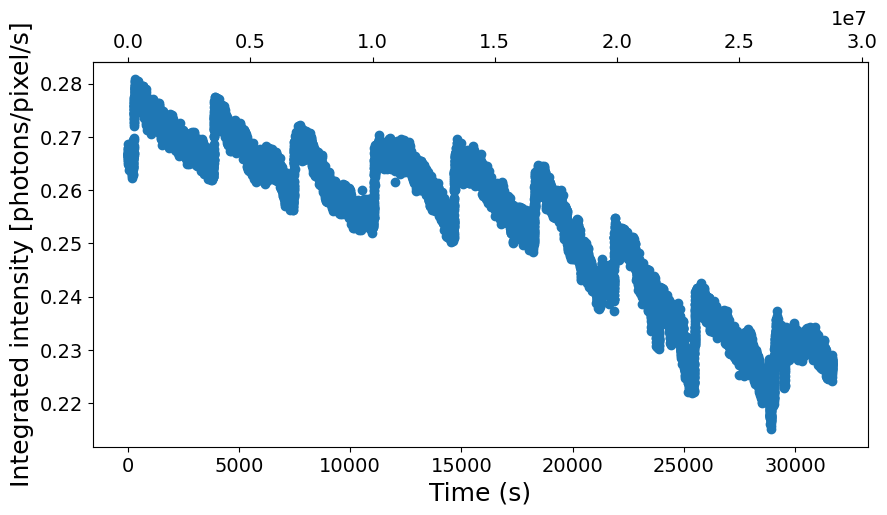

In [8]:
plt.figure(figsize=(10,5))
plt.scatter(t_It, It, label='It')
plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))
#plt.xscale('log')
plt.show()

### Linear correlation 4 tests

In [34]:
###################
Nfi = None
Nff = None
Lbin = 10000
bin2dense = True
mask = None
###################
if Lbin is None: Lbin=1

G2t = XPCS.get_G2t(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, bin2dense=bin2dense)

Loading frames ...
Done! (elapsed time = 0.0 s)
Binning frames (Lbin = 10000, using MKL library) ...


Exception ignored in: <function ResourceTracker.__del__ at 0x706b1763bce0>
Traceback (most recent call last):
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7fdccf49bce0>
Traceback (most recent call last):
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", li

Done! (elapsed time = 93.55 s)
	 | 2880 frames X 1093772 pixels
	 | memory usage (np.array @ float32) = 11.735 GB
Computing G2t (using MKL library)...
Done! (elapsed time = 3.68 s)
	 | 2880 X 2880 squared matrix
	 | memory usage (np.array @ float32) = 0.031 GB
Normalizing G2t (using NumExpr library)...
Done! (elapsed time = 0.53 s)



In [35]:
############################
t1, t2 = 0, 300
vmin, vmax = 1.0, 1.015
############################
#XPCS.plot_G2t(G2t, vmin, vmax, itime*Lbin, t1=t1, t2=t2, sigma_filter=5)

In [36]:
################
Nbunch = 1
################

NfXbunch = int(G2t.shape[0]/Nbunch)
t_g2, g2, dg2, t_mt, g2_mt, dg2_mt = {}, {}, {}, {}, {}, {}
for n in range(Nbunch):
    if Nfi is None: Nfi = 0
    t_bunch = Nfi*itime + round(itime*Lbin*NfXbunch*(n+1/2),1)

    if Nbunch!=1: t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t[NfXbunch*n:NfXbunch*(n+1), NfXbunch*n:NfXbunch*(n+1)]))
    else:         t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t))
    t_mt[t_bunch], g2_mt[t_bunch], dg2_mt[t_bunch] = XPCS.get_g2mt_fromling2(itime*Lbin, g2[t_bunch],dg2[t_bunch])   


Computing g2 (using cython code)...
Done! (elapsed time = 0.02 s)



/gpfs/jazzy/data/visitor/hc6211/id10-coh/20250527/SCRIPTS_Trento/XPCSlibrary/XPCS_tools.py:827: RuntimeWarning: invalid value encountered in sqrt
  if    G2t.dtype==np.float32: g2, dg2 = mean_trace_float32(G2t)


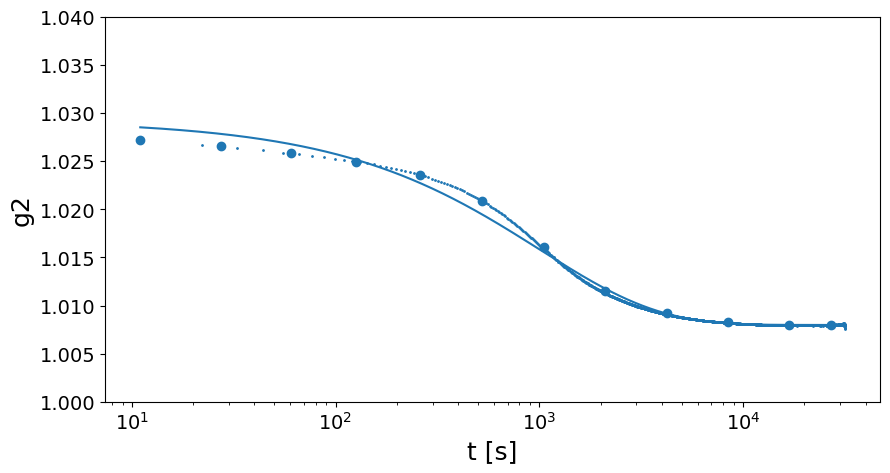

name,value,standard error,relative error,initial value,min,max,vary
tau,1007.78646,7.29207998,(0.72%),1000,0.00000000,1000000.00,True
beta,0.74153880,0.00302686,(0.41%),1,0.00000000,2.00000000,True
c,0.02126858,7.7524e-05,(0.36%),0.02,0.00000000,1.00000000,True
y0,1.00798484,1.6322e-06,(0.00%),1,0.00000000,2.00000000,True


In [37]:
##################
t1_fit = 0
t2_fit = 1e100
##################

#####################################################
model = lm.Model(decorrelation_f)
params = lm.Parameters()
params.add('tau', value=1000, min=0, max=1e6)
params.add('beta', value=1, min=0, max=2)
params.add('c', value=.02, min=0, max=1)
params.add('y0', value=1, min=0, max=2)
#params.add('y0', value=1.015, vary=False)
#####################################################
 
plt.figure(figsize=(10,5))
g2_fit = pd.DataFrame(columns=['Q', 'dQ', 'tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
g2_fit.index.name = 't'
for i,k in enumerate(g2.keys()):
    plt.scatter(t_g2[k], g2[k], s=1, c='C'+str(i), label = str(k)+'s')
    t_mt, g2_mt, dg2_mt = XPCS.get_g2mt_fromling2(itime*Lbin, g2[k], dg2[k])
    plt.errorbar(t_mt, g2_mt, yerr=dg2_mt, fmt = 'o', c='C'+str(i), label=str(k)+'s')
    
    x = t_g2[k] [(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    y = g2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    dy = dg2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    fit = model.fit(y, params, t=x, method='least_squares', weights=1/dy)
    g2_fit.loc[k] = [Q, dq, fit.params['tau'].value, fit.params['beta'].value, fit.params['c'].value, fit.params['y0'].value, fit.params['tau'].stderr, fit.params['beta'].stderr, fit.params['c'].stderr, fit.params['y0'].stderr]

    x = np.arange(np.min(t_g2[k]), np.max(t_g2[k]), 1e-2)
    y = decorrelation_f(x, *g2_fit.loc[k].values[2:6])
    plt.plot(x, y,)

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.ylim(1, 1.04)
#plt.legend()
plt.show()

if Nbunch == 1:
    display(fit.params)
else:
    plt.figure(figsize=(10,5))
    plt.title('tau')
    plt.errorbar(g2_fit.index, g2_fit.tau,  yerr=g2_fit.dtau, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('tau [s]')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('beta')
    plt.errorbar(g2_fit.index, g2_fit.beta,  yerr=g2_fit.dbeta, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('beta')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('c')
    plt.errorbar(g2_fit.index, g2_fit.c,  yerr=g2_fit.dc, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('c')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('y0')
    plt.errorbar(g2_fit.index, g2_fit.y0,  yerr=g2_fit.dy0, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('y0')
    plt.tight_layout(); plt.show()

### Linear by dose

In [38]:
t_ff = e4m_data.shape[0]*itime
print('#############################')
print('Nff =    =',e4m_data.shape[0], ' =>  t_ff =', t_ff)
print('#############################\n')

#############################
Nff =    = 28800048  =>  t_ff = 31680.0528
#############################



In [39]:
########################################
#N_segments = 5
t_segments = [0, 5000, 10000, 15000, 20000, 31680] #np.linspace(0, int(t_ff), N_segments)
#t_segments = [0, 50, 200, 500, 1000]#[0, 400, 1500, 6000, 15500]
t_skip = [] # skip if Nfi is in t_skip
########################################

Nf_segments = [int (t/itime) for t in t_segments]
Nf_skip = [int(t/itime) for t in t_skip]

In [40]:
###################
Lbin = 100
bin2dense = False
mask = None
###################

t_g2, g2, dg2= {}, {}, {}
for i in tqdm(range(len(Nf_segments)-1)):
    with redirect_stdout(io.StringIO()):
        Nfi = Nf_segments[i]
        Nff = Nf_segments[i+1]
        if not Nfi in Nf_skip:
            G2t = XPCS.get_G2t(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, bin2dense=bin2dense)
            t_bunch = Nfi*itime + (Nff-Nfi)/2*itime
            t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t))
np.savez(g2_folder+'g2_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq), t_g2=t_g2, g2=g2, dg2=dg2)

100%|██████████| 5/5 [10:27<00:00, 125.43s/it]


/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects w

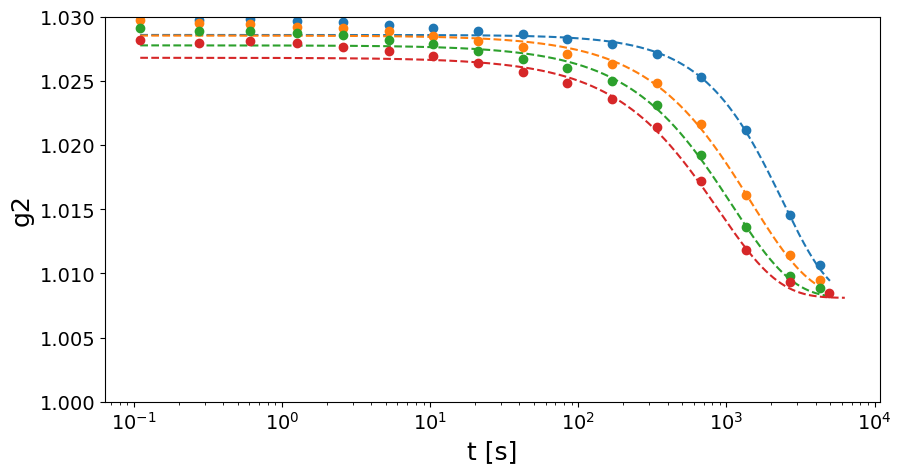

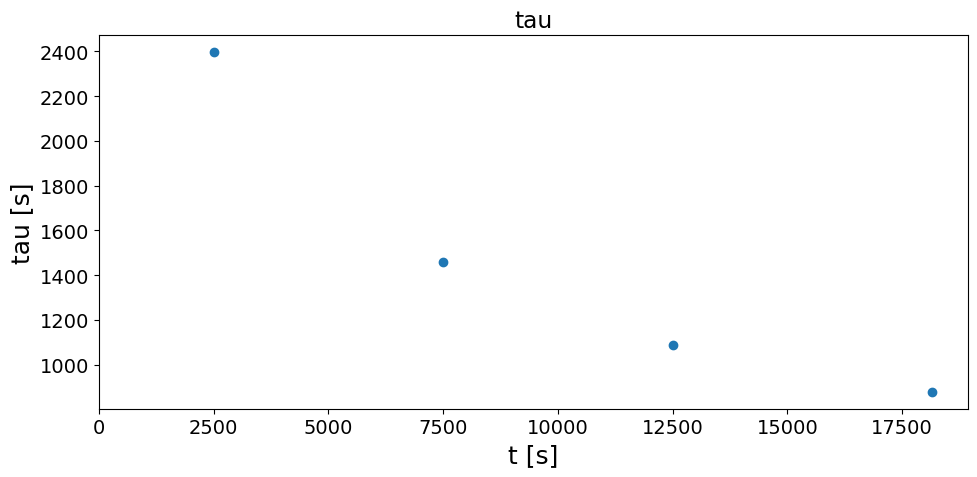

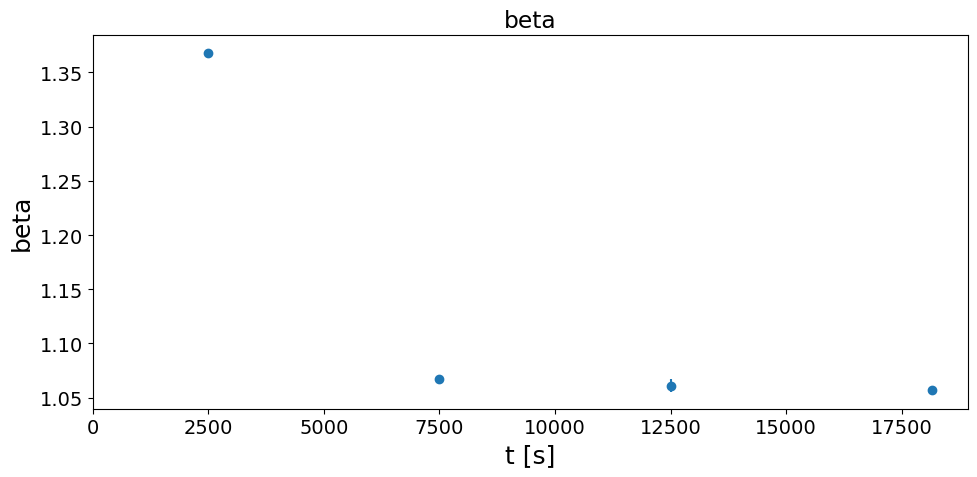

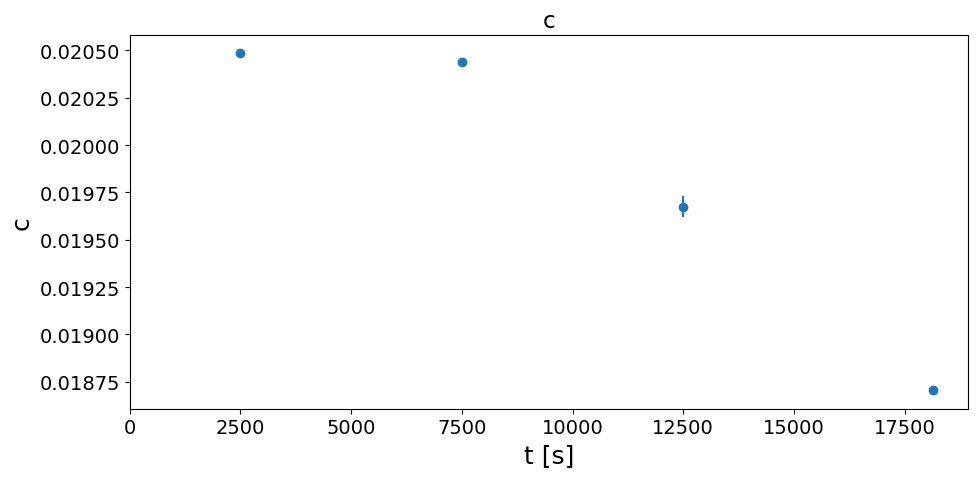

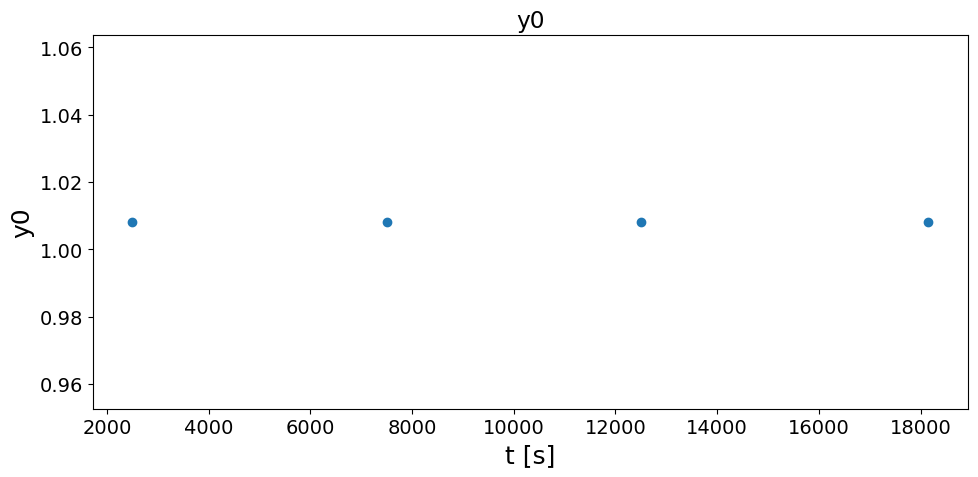

In [ ]:
##################
t1_fit = 0
t2_fit = 1e10
##################

#####################################################
model = lm.Model(decorrelation_f)
params = lm.Parameters()
params.add('tau', value=50, min=0, max=1e6)
params.add('beta', value=0.8, min=0, max=2)
params.add('c', value=.02, min=0, max=1)
#params.add('y0', value=1, min=0, max=2)
params.add('y0', value=	1.00798484, vary=False)
#####################################################
 
plt.figure(figsize=(10,5))
g2_fit = pd.DataFrame(columns=['Q', 'dQ', 'tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
g2_fit.index.name = 't'
for i,k in enumerate(g2.keys()):
    #plt.scatter(t_g2[k], g2[k], s=1, c='C'+str(i), label = str(k)+'s')
    t_mt, g2_mt, dg2_mt = XPCS.get_g2mt_fromling2(itime*Lbin, g2[k], dg2[k])
    plt.errorbar(t_mt, g2_mt, yerr=dg2_mt, fmt = 'o', c='C'+str(i), label=str(k)+'s')

    x = t_g2[k] [(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    y = g2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    dy = dg2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    fit = model.fit(y, params, t=x, method='least_squares', weights=1/dy)
    g2_fit.loc[k] = [Q, dq, fit.params['tau'].value, fit.params['beta'].value, fit.params['c'].value, fit.params['y0'].value, fit.params['tau'].stderr, fit.params['beta'].stderr, fit.params['c'].stderr, fit.params['y0'].stderr]

    x = np.arange(np.min(t_g2[k]), np.max(t_g2[k]), 1e-2)
    y = decorrelation_f(x, *g2_fit.loc[k].values[2:6])
    plt.plot(x, y, c='C'+str(i), linestyle='--')

g2_fit.to_csv(g2fit_folder+'g2fit_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq)+'.csv')

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.ylim(1, 1.03)
#plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title('tau')
plt.errorbar(g2_fit.index, g2_fit.tau,  yerr=g2_fit.dtau, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('tau [s]')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('beta')
plt.errorbar(g2_fit.index, g2_fit.beta,  yerr=g2_fit.dbeta, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('beta')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('c')
plt.errorbar(g2_fit.index, g2_fit.c,  yerr=g2_fit.dc, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('c')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('y0')
plt.errorbar(g2_fit.index, g2_fit.y0,  yerr=g2_fit.dy0, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('y0')
plt.tight_layout(); plt.show()

## XPCS scan: delcoup=8, T=30min (Ta2O5_2.5um_AsDep_B, 1, 105)  

Misura per trovare la baseline della mesh

#############################
command = mtimescan 0.001 1 1500240
Ei = 21.669991317784486
itime = 0.0011
T =  0.4584066666666667 h
theta = 10.4
Qc = 1.99
#############################



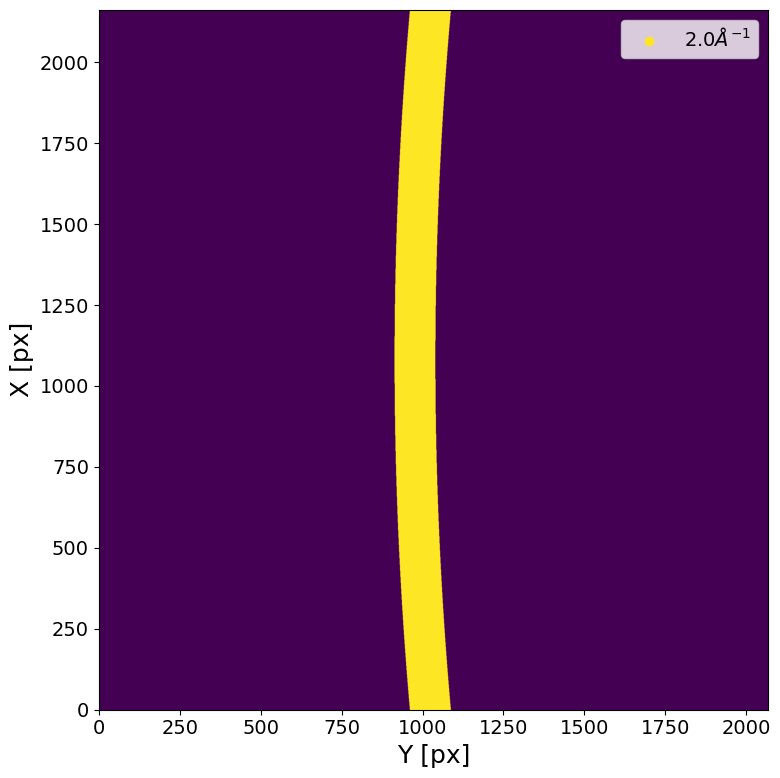

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/300 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/300 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/300 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00003.h5 (4/300 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00004.h5 (5/300 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00050.h5 (51/300 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00051.h5 (52/300 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00052.h5 (53/300 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00053.h5 (54/300 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00054.h5 (55/300 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00055.h5 (56/300 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00056.h5 (57/300 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00057.h5 (58/300 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00058.h5 (59/300 loops)
	 -> loading file eiger4m_v2

Exception ignored in: <function ResourceTracker.__del__ at 0x799f80647ce0>
Traceback (most recent call last):
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x758838297ce0>
Traceback (most recent call last):
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", li

In [ ]:
#######################################
sample_name = 'Ta2O5_2.5um_AsDep_B'
Ndataset = 1
Nscan = 105
#######################################

scan = ID10.load_scan(RAW_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
T = scan['fast_timer_period'].size*itime
theta = scan['delcoup']
Qc = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('T = ', T/60**2, 'h')
print('theta =', theta)
print('Qc =', Qc)
print('#############################\n')

#################################################################################
Nfi, Nff = None, len(scan['fast_timer_period'])-5001
Qmask = XPCS.gen_Qmask(Ei, theta, Q, dq, Qmap_plot=False)
load_mask = e4m_mask*e4m_htmask*Qmask
##################################################################################

e4m_data = ID10.load_sparse_e4m(RAW_folder, sample_name, Ndataset, Nscan, Nfi=Nfi, Nff=Nff, load_mask=load_mask, n_jobs=50, )

### Flux check

################################################################################
Maximum count in the whole run -> 3.0
# of pixels above Ith_high treshold ->  4275344 pixels (of 4471016 => 95.62 %)
################################################################################



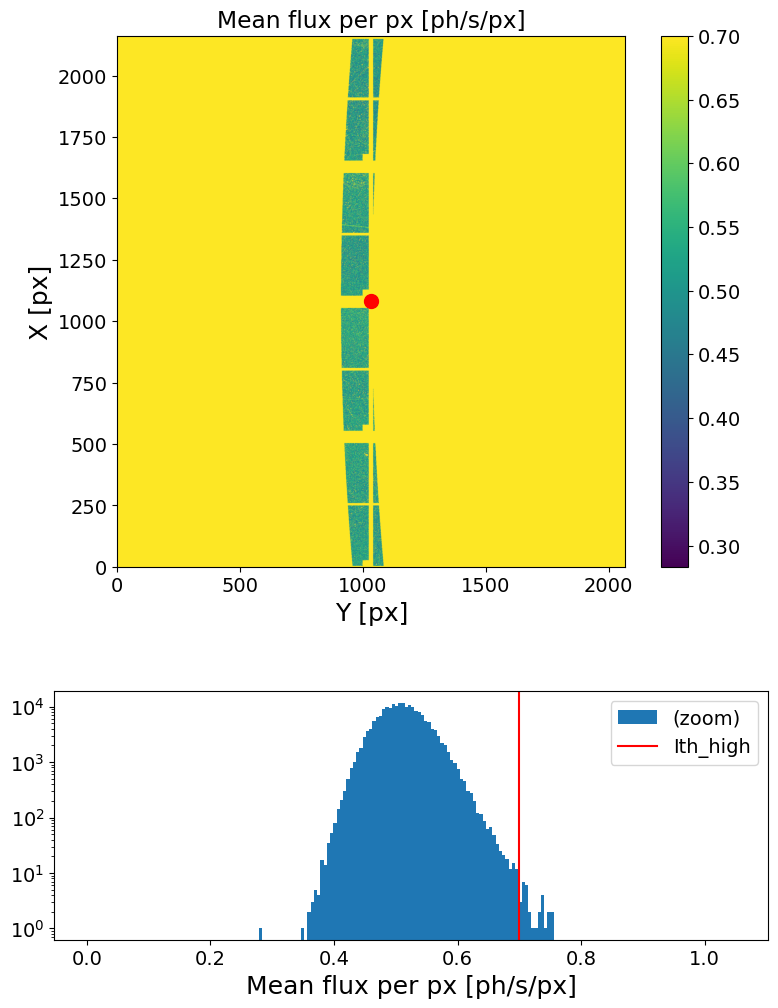

In [ ]:
XPCS.gen_plots4mask(e4m_data, itime, Ith_high=.7, Nfi=None, Nff=int(1e7), load_mask=load_mask, mask=None)

### Intensity analysis

In [ ]:
####################
Lbin = 100
Nstep = 100
mask = None
Nfi = None
Nff = None
####################

t_It, It = XPCS.get_It(e4m_data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep, Nfi=Nfi, Nff=Nff)
np.savez(It_folder+'Idt_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq), t_It=t_It, It=It)

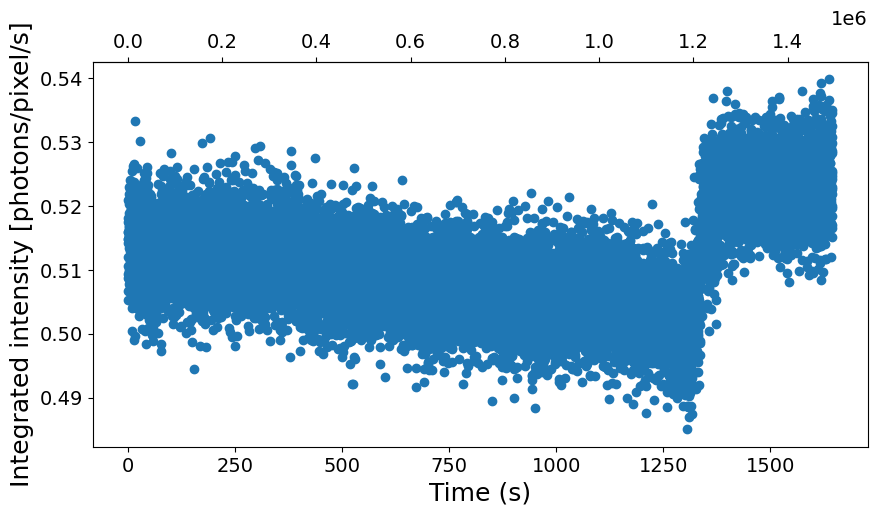

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(t_It, It, label='It')
plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))
#plt.xscale('log')
plt.show()

### Linear correlation 4 tests

In [ ]:
###################
Nfi = None
Nff = None
Lbin = 1000
bin2dense = True
mask = None
###################
if Lbin is None: Lbin=1

G2t = XPCS.get_G2t(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, bin2dense=bin2dense)

Loading frames ...
Done! (elapsed time = 0.0 s)
Binning frames (Lbin = 1000, using MKL library) ...
Done! (elapsed time = 1.51 s)
	 | 1495 frames X 195702 pixels
	 | memory usage (np.array @ float32) = 1.09 GB
Computing G2t (using MKL library)...
Done! (elapsed time = 0.27 s)
	 | 1495 X 1495 squared matrix
	 | memory usage (np.array @ float32) = 0.008 GB
Normalizing G2t (using NumExpr library)...
Done! (elapsed time = 0.05 s)



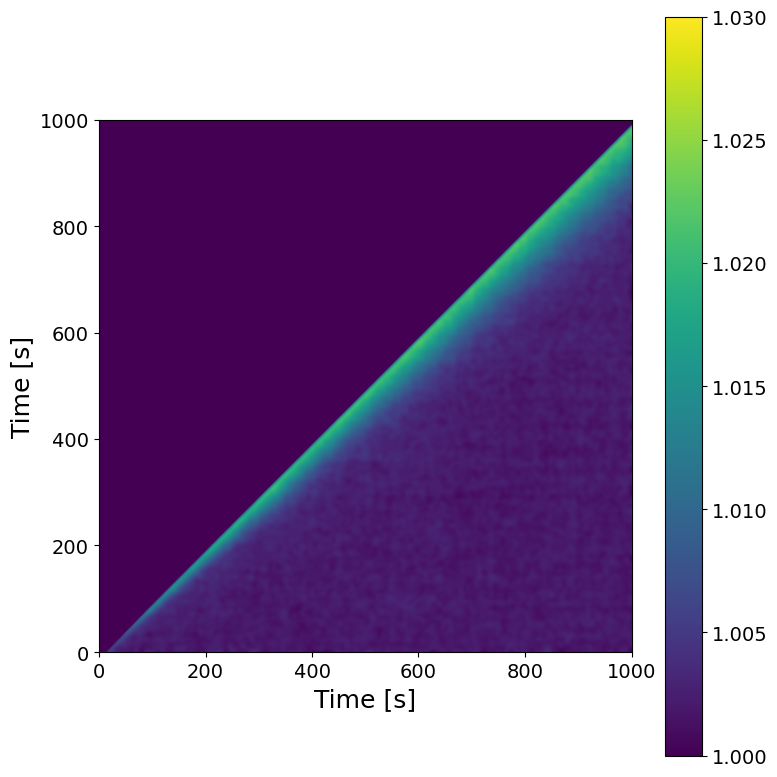

In [ ]:
############################
t1, t2 = 0, 1000
vmin, vmax = 1.0, 1.03
############################
XPCS.plot_G2t(G2t, vmin, vmax, itime*Lbin, t1=t1, t2=t2, sigma_filter=4)

In [ ]:
################
Nbunch = 1
################

NfXbunch = int(G2t.shape[0]/Nbunch)
t_g2, g2, dg2, t_mt, g2_mt, dg2_mt = {}, {}, {}, {}, {}, {}
for n in range(Nbunch):
    if Nfi is None: Nfi = 0
    t_bunch = Nfi*itime + round(itime*Lbin*NfXbunch*(n+1/2),1)

    if Nbunch!=1: t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t[NfXbunch*n:NfXbunch*(n+1), NfXbunch*n:NfXbunch*(n+1)]))
    else:         t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t))
    t_mt[t_bunch], g2_mt[t_bunch], dg2_mt[t_bunch] = XPCS.get_g2mt_fromling2(itime*Lbin, g2[t_bunch],dg2[t_bunch])   


Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)



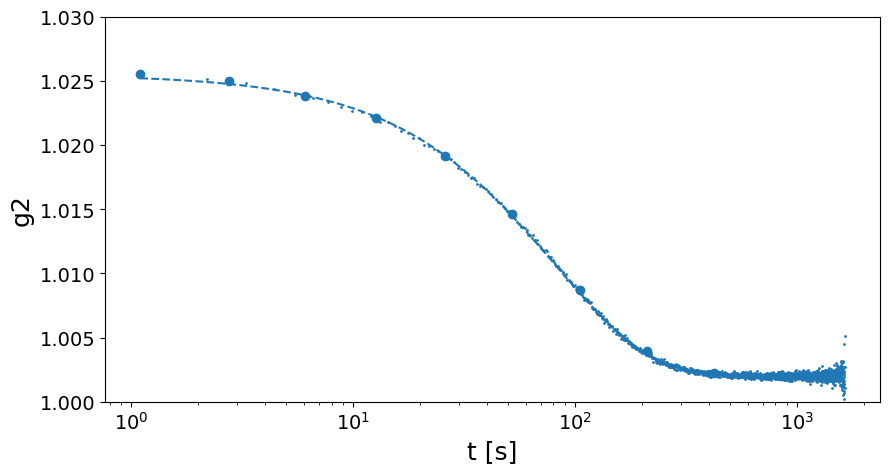

name,value,standard error,relative error,initial value,min,max,vary
tau,81.5192260,0.26128028,(0.32%),1000,0.00000000,1000000.00,True
beta,1.01338908,0.00376567,(0.37%),1,0.00000000,2.00000000,True
c,0.02348894,4.8733e-05,(0.21%),0.02,0.00000000,1.00000000,True
y0,1.00202644,5.1624e-06,(0.00%),1,0.00000000,2.00000000,True


In [ ]:
##################
t1_fit = 0
t2_fit = 1e100
##################

#####################################################
model = lm.Model(decorrelation_f)
params = lm.Parameters()
params.add('tau', value=1000, min=0, max=1e6)
params.add('beta', value=1, min=0, max=2)
params.add('c', value=.02, min=0, max=1)
params.add('y0', value=1, min=0, max=2)
#params.add('y0', value=1.015, vary=False)
#####################################################
 
plt.figure(figsize=(10,5))
g2_fit = pd.DataFrame(columns=['Q', 'dQ', 'tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
g2_fit.index.name = 't'
for i,k in enumerate(g2.keys()):
    plt.scatter(t_g2[k], g2[k], s=1, c='C'+str(i), label = str(k)+'s')
    t_mt, g2_mt, dg2_mt = XPCS.get_g2mt_fromling2(itime*Lbin, g2[k], dg2[k])
    plt.errorbar(t_mt, g2_mt, yerr=dg2_mt, fmt = 'o', c='C'+str(i), label=str(k)+'s')

    x = t_g2[k] [(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    y = g2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    dy = dg2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    fit = model.fit(y, params, t=x, method='least_squares', weights=1/dy)
    g2_fit.loc[k] = [Q, dq, fit.params['tau'].value, fit.params['beta'].value, fit.params['c'].value, fit.params['y0'].value, fit.params['tau'].stderr, fit.params['beta'].stderr, fit.params['c'].stderr, fit.params['y0'].stderr]

    x = np.arange(np.min(t_g2[k]), np.max(t_g2[k]), 1e-2)
    y = decorrelation_f(x, *g2_fit.loc[k].values[2:6])
    plt.plot(x, y, c='C'+str(i), linestyle='--')

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.ylim(1, 1.03)
#plt.legend()
plt.show()

if Nbunch == 1:
    display(fit.params)
else:
    plt.figure(figsize=(10,5))
    plt.title('tau')
    plt.errorbar(g2_fit.index, g2_fit.tau,  yerr=g2_fit.dtau, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('tau [s]')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('beta')
    plt.errorbar(g2_fit.index, g2_fit.beta,  yerr=g2_fit.dbeta, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('beta')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('c')
    plt.errorbar(g2_fit.index, g2_fit.c,  yerr=g2_fit.dc, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('c')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('y0')
    plt.errorbar(g2_fit.index, g2_fit.y0,  yerr=g2_fit.dy0, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('y0')
    plt.tight_layout(); plt.show()

## XPCS scan: delcoup=8, T=20min (Ta2O5_2.5um_AsDep_B, 1, 55-104)  

Mesh

#############################
command = mtimescan 0.001 1 40128
Ei = 21.669991317784486
itime = 0.0011
T =  0.012261333333333334 h
theta = 8.0
Qc = 1.53
#############################



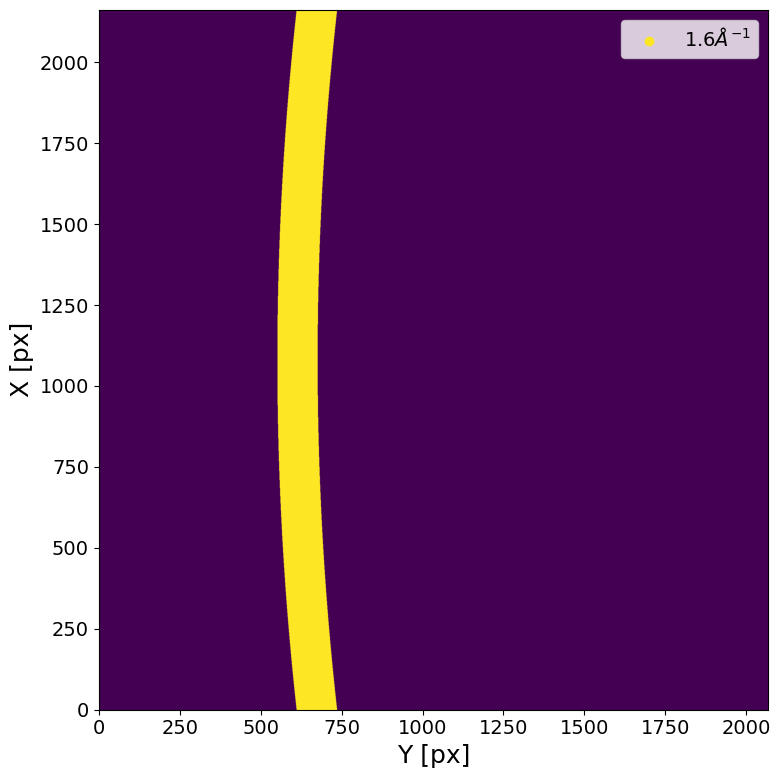

100%|██████████| 25/25 [00:25<00:00,  1.01s/it]


In [38]:
#######################################
sample_name = 'Ta2O5_2.5um_AsDep_B'
Ndataset = 1
Nscan = range(55, 80)
#######################################

scan = ID10.load_scan(RAW_folder, sample_name, Ndataset, Nscan[0])
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
T = scan['fast_timer_period'].size*itime
theta = scan['delcoup']
Qc = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('T = ', T/60**2, 'h')
print('theta =', theta)
print('Qc =', Qc)
print('#############################\n')

#################################################################################
Qmask = XPCS.gen_Qmask(Ei, theta, Q, dq, Qmap_plot=False)
load_mask = e4m_mask*e4m_htmask*Qmask
##################################################################################

e4m_data = []
for n in tqdm(Nscan):
    with redirect_stdout(io.StringIO()):
        e4m_data.append(ID10.load_sparse_e4m(RAW_folder, sample_name, Ndataset, n, Nfi=None, Nff=None, load_mask=load_mask, n_jobs=1, ))


### Flux check

In [ ]:
#XPCS.gen_plots4mask(e4m_data, itime, Ith_high=.5, Nfi=None, Nff=int(1e7), load_mask=load_mask, mask=None)

### Intensity analysis

In [39]:
####################
Lbin = 1
Nstep = 1
mask = None
####################

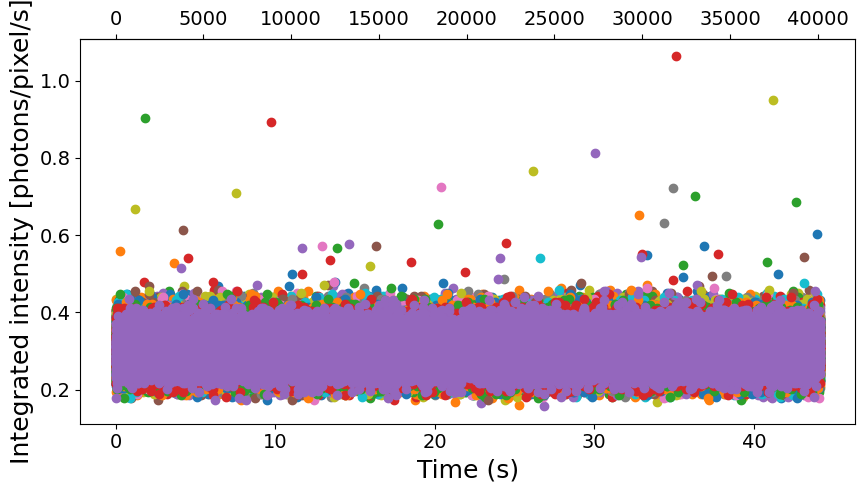

In [40]:
plt.figure(figsize=(10,5))
for data in e4m_data:
    t_It, It = XPCS.get_It(data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep)
    plt.scatter(t_It, It, label='It')
    
plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))
#plt.xscale('log')
plt.show()

### Linear correlation 4 tests

In [41]:
###################
Lbin = 10
bin2dense = False
mask = None
###################
if Lbin is None: Lbin=1

G2t = np.zeros((e4m_data[0].shape[0]//Lbin,e4m_data[0].shape[0]//Lbin))

for data in tqdm(e4m_data):
    with redirect_stdout(io.StringIO()):
        G2t += XPCS.get_G2t(data, mask=mask, Lbin=Lbin, bin2dense=bin2dense)

G2t/=len(e4m_data)

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:08<00:00,  2.94it/s]


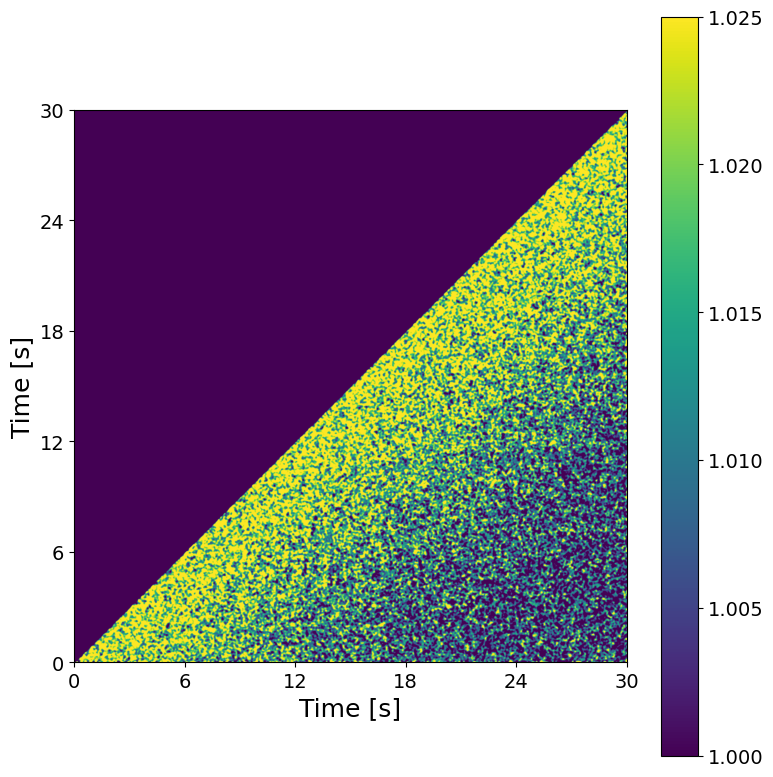

In [44]:
############################
vmin, vmax = 1.0, 1.025
############################
XPCS.plot_G2t(G2t, vmin, vmax, itime*Lbin, t1=t1, t2=t2, sigma_filter=4)

In [45]:
################
Nbunch = 1
################

NfXbunch = int(G2t.shape[0]/Nbunch)
t_g2, g2, dg2, t_mt, g2_mt, dg2_mt = {}, {}, {}, {}, {}, {}
for n in range(Nbunch):
    Nfi = 0
    t_bunch = Nfi*itime + round(itime*Lbin*NfXbunch*(n+1/2),1)

    if Nbunch!=1: t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t[NfXbunch*n:NfXbunch*(n+1), NfXbunch*n:NfXbunch*(n+1)]))
    else:         t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t))
    t_mt[t_bunch], g2_mt[t_bunch], dg2_mt[t_bunch] = XPCS.get_g2mt_fromling2(itime*Lbin, g2[t_bunch],dg2[t_bunch])   


Computing g2 (using cython code)...
Done! (elapsed time = 0.01 s)



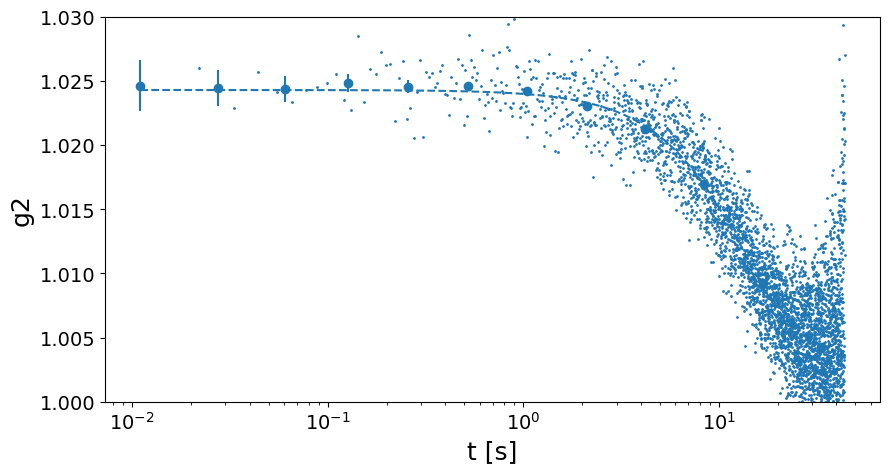

name,value,standard error,relative error,initial value,min,max,vary
tau,14.1553063,0.17004581,(1.20%),10,0.00000000,1000000.00,True
beta,1.59476962,0.03796118,(2.38%),1,0.00000000,2.00000000,True
c,0.02091549,2.5577e-04,(1.22%),0.02,0.00000000,1.00000000,True
y0,1.00338218,1.6634e-04,(0.02%),1,0.00000000,2.00000000,True


In [46]:
##################
t1_fit = 0
t2_fit = 1e100
##################

#####################################################
model = lm.Model(decorrelation_f)
params = lm.Parameters()
params.add('tau', value=10, min=0, max=1e6)
params.add('beta', value=1, min=0, max=2)
params.add('c', value=.02, min=0, max=1)
params.add('y0', value=1, min=0, max=2)
#params.add('y0', value=1.004014, vary=False)
#####################################################
 
plt.figure(figsize=(10,5))
g2_fit = pd.DataFrame(columns=['Q', 'dQ', 'tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
g2_fit.index.name = 't'
for i,k in enumerate(g2.keys()):
    plt.scatter(t_g2[k], g2[k], s=1, c='C'+str(i), label = str(k)+'s')
    t_mt, g2_mt, dg2_mt = XPCS.get_g2mt_fromling2(itime*Lbin, g2[k], dg2[k])
    plt.errorbar(t_mt, g2_mt, yerr=dg2_mt, fmt = 'o', c='C'+str(i), label=str(k)+'s')

    x = t_g2[k] [(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    y = g2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    dy = dg2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    fit = model.fit(y, params, t=x, method='least_squares', weights=1/dy)
    g2_fit.loc[k] = [Q, dq, fit.params['tau'].value, fit.params['beta'].value, fit.params['c'].value, fit.params['y0'].value, fit.params['tau'].stderr, fit.params['beta'].stderr, fit.params['c'].stderr, fit.params['y0'].stderr]

    x = np.arange(np.min(t_g2[k]), np.max(t_g2[k]), 1e-2)
    y = decorrelation_f(x, *g2_fit.loc[k].values[2:6])
    plt.plot(x, y, c='C'+str(i), linestyle='--')

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.ylim(1, 1.03)
#plt.legend()
plt.show()

if Nbunch == 1:
    display(fit.params)
else:
    plt.figure(figsize=(10,5))
    plt.title('tau')
    plt.errorbar(g2_fit.index, g2_fit.tau,  yerr=g2_fit.dtau, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('tau [s]')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('beta')
    plt.errorbar(g2_fit.index, g2_fit.beta,  yerr=g2_fit.dbeta, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('beta')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('c')
    plt.errorbar(g2_fit.index, g2_fit.c,  yerr=g2_fit.dc, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('c')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('y0')
    plt.errorbar(g2_fit.index, g2_fit.y0,  yerr=g2_fit.dy0, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('y0')
    plt.tight_layout(); plt.show()

### Linear by dose

In [ ]:
t_ff = e4m_data[0].shape[0]*itime
print('#############################')
print('Nff =    =',e4m_data[0].shape[0], ' =>  t_ff =', t_ff)
print('#############################\n')

#############################
Nff =    = 20064  =>  t_ff = 22.070400000000003
#############################



In [ ]:
########################################
t_segments = [0, 6, 12, t_ff] 
########################################

Nf_segments = [int (t/itime) for t in t_segments]
Nf_skip = [int(t/itime) for t in t_skip]

In [ ]:
###################
Lbin = 10
bin2dense = False
mask = None
###################

t_g2, g2, dg2= {}, {}, {}
for i in range(len(Nf_segments)-1):
        Nfi = Nf_segments[i]
        Nff = Nf_segments[i+1]
        if not Nfi in Nf_skip:
            G2t = np.zeros(((Nff-Nfi)//Lbin, (Nff-Nfi)//Lbin))
            for data in tqdm(e4m_data):
                with redirect_stdout(io.StringIO()):
                    G2t += XPCS.get_G2t(data, mask=mask, Lbin=Lbin, bin2dense=bin2dense, Nfi=Nfi, Nff=Nff)
            G2t/=len(e4m_data)
            t_bunch = Nfi*itime + (Nff-Nfi)/2*itime
            t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t))
np.savez(g2_folder+'g2_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq), t_g2=t_g2, g2=g2, dg2=dg2)

100%|██████████| 50/50 [00:01<00:00, 48.03it/s]


Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)



100%|██████████| 50/50 [00:00<00:00, 50.21it/s]


Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)



100%|██████████| 50/50 [00:02<00:00, 22.72it/s]


Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)



/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


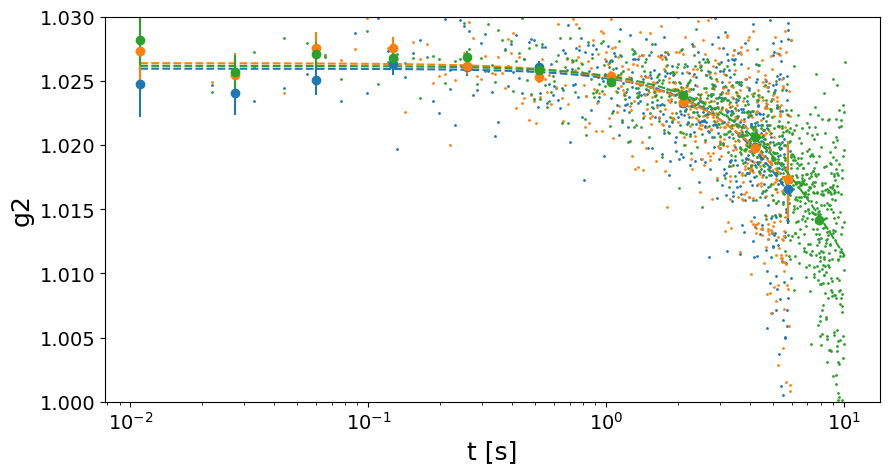

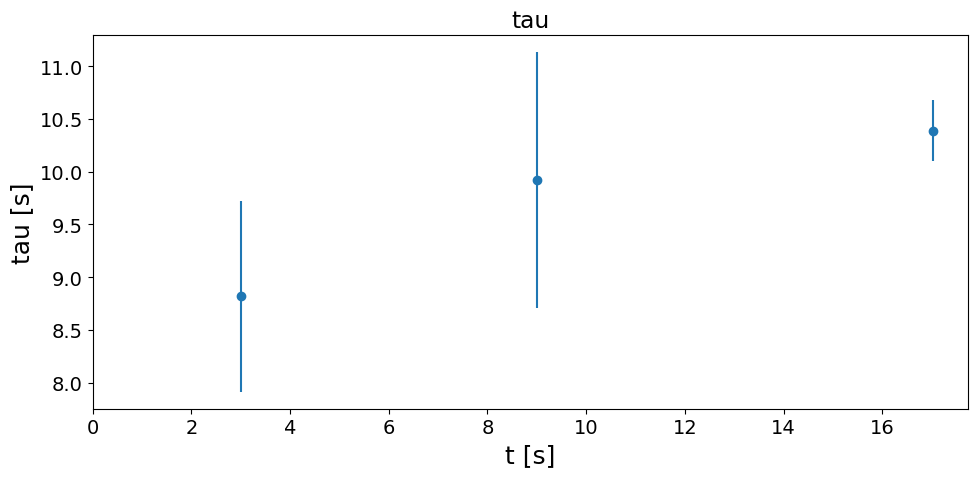

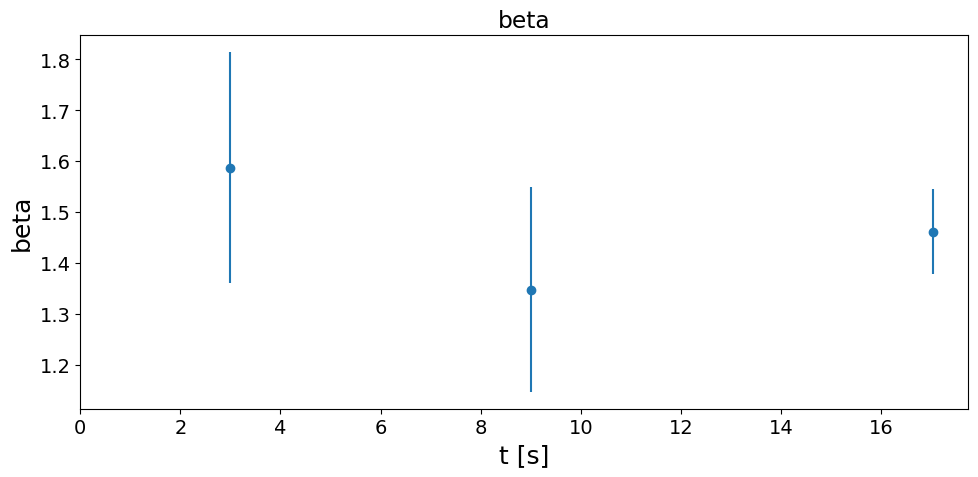

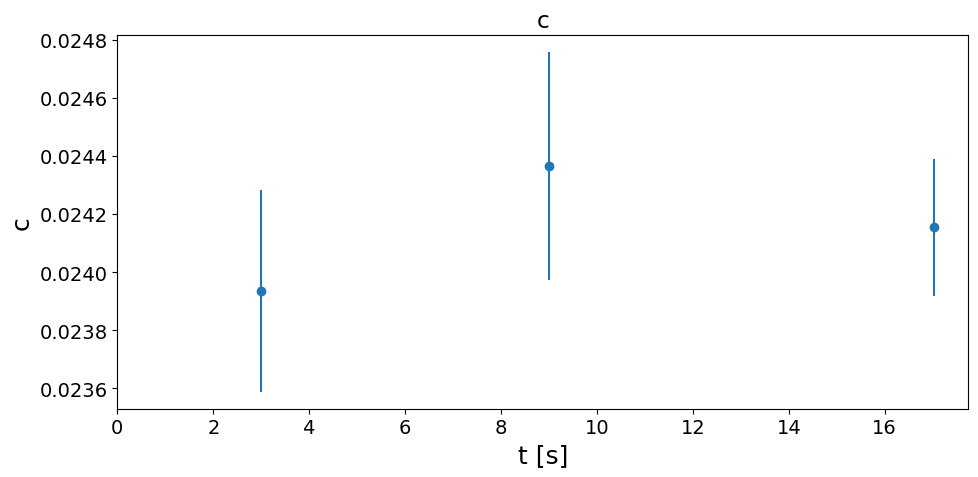

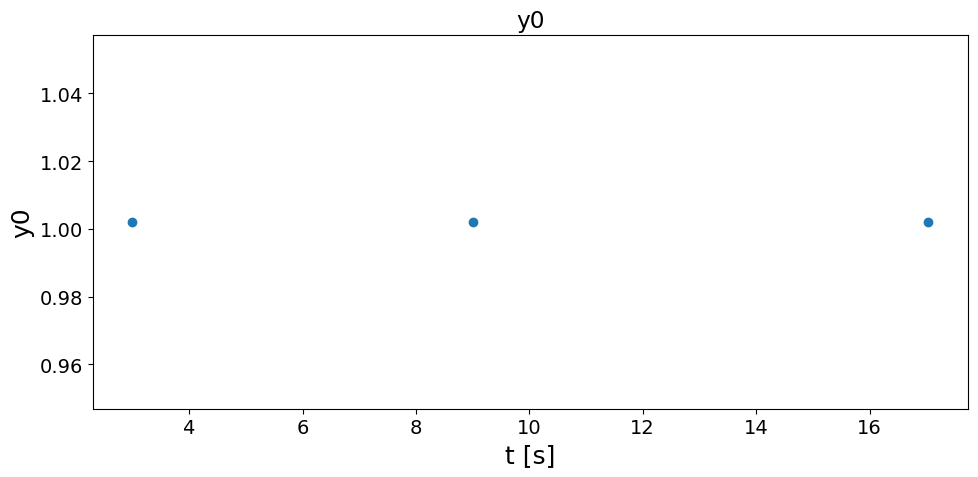

In [ ]:
##################
t1_fit = 0
t2_fit = 1e10
##################

#####################################################
model = lm.Model(decorrelation_f)
params = lm.Parameters()
params.add('tau', value=50, min=0, max=1e6)
params.add('beta', value=0.8, min=0, max=2)
params.add('c', value=.02, min=0, max=1)
params.add('y0', value=1.00202644, vary=False)
#####################################################
 
plt.figure(figsize=(10,5))
g2_fit = pd.DataFrame(columns=['Q', 'dQ', 'tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
g2_fit.index.name = 't'
for i,k in enumerate(g2.keys()):
    plt.scatter(t_g2[k], g2[k], s=1, c='C'+str(i), label = str(k)+'s')
    t_mt, g2_mt, dg2_mt = XPCS.get_g2mt_fromling2(itime*Lbin, g2[k], dg2[k])
    plt.errorbar(t_mt, g2_mt, yerr=dg2_mt, fmt = 'o', c='C'+str(i), label=str(k)+'s')

    x = t_g2[k] [(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    y = g2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    dy = dg2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    fit = model.fit(y, params, t=x, method='least_squares', weights=1/dy)
    g2_fit.loc[k] = [Q, dq, fit.params['tau'].value, fit.params['beta'].value, fit.params['c'].value, fit.params['y0'].value, fit.params['tau'].stderr, fit.params['beta'].stderr, fit.params['c'].stderr, fit.params['y0'].stderr]

    x = np.arange(np.min(t_g2[k]), np.max(t_g2[k]), 1e-2)
    y = decorrelation_f(x, *g2_fit.loc[k].values[2:6])
    plt.plot(x, y, c='C'+str(i), linestyle='--')

g2_fit.to_csv(g2fit_folder+'g2fit_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq)+'.csv')

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.ylim(1, 1.03)
#plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title('tau')
plt.errorbar(g2_fit.index, g2_fit.tau,  yerr=g2_fit.dtau, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('tau [s]')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('beta')
plt.errorbar(g2_fit.index, g2_fit.beta,  yerr=g2_fit.dbeta, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('beta')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('c')
plt.errorbar(g2_fit.index, g2_fit.c,  yerr=g2_fit.dc, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('c')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('y0')
plt.errorbar(g2_fit.index, g2_fit.y0,  yerr=g2_fit.dy0, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('y0')
plt.tight_layout(); plt.show()